## DQN 특징

1. 더 깊은 네트워크 사용
2. experience replay 사용
3. separate network 사용

cartpole-v2는 cartpole-v1에서 아래와 같은 수정된 점이 있음

* pole의 각도가 (12도 -> 90도) 이상 쓰러질 경우 terminated
* pole의 위치가 (+-0.05 -> +- 1.0)에 초기에 생성됨

pole의 위치와 중심 사이의 거리에 따라 reward를 일정량 깎아서 pole이 중심에 위치하도록 학습을 유도한 버전

In [1]:
import gymnasium
from gymnasium.envs.registration import register
import numpy as np
import random
import torch
import copy
import collections
import math
import itertools
from tqdm import tqdm

In [2]:
class ReplayBuffer:
    Transition = collections.namedtuple('Transition', 'state action reward next_state terminated')

    def __init__(self, capacity):
        self.memory = collections.deque(maxlen=capacity)
    
    def sample(self, batch_size):
        return self.Transition(*(torch.tensor(np.array(i)) for i in zip(*random.sample(self.memory, batch_size))))
    
    def append(self, state, action, reward, next_state, terminated):
        self.memory.append(self.Transition(
            np.array(state, dtype=np.float32),
            np.array(action, dtype=np.int64),
            np.array(reward, dtype=np.float32),
            np.array(next_state, dtype=np.float32),
            np.array(terminated, dtype=np.bool8),
        ))

    def __len__(self):
        return len(self.memory)

In [3]:
register(
    id='CartPole-v2',
    entry_point='cartpole_v2:CartPoleEnv',
    max_episode_steps=500,
)
env = gymnasium.make('CartPole-v2')
hidden_size = 128
q = torch.nn.Sequential(
    torch.nn.Linear(*env.observation_space.shape, hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, env.action_space.n)
)
target_q = copy.deepcopy(q)

In [4]:
lr = 0.0001
discount = 0.99
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(q.parameters(), lr=lr)
replay_buffer = ReplayBuffer(10000)
num_episodes = 600
batch_size = 128
eps_start = 0.9
eps_end = 0.05
eps_decay = 1000
tau = 0.005

In [5]:
scores = []
action_count = 0
for i in tqdm(range(num_episodes)):
    state, info = env.reset()
    score = 0
    for step in itertools.count():
        eps = eps_end + (eps_start - eps_end) * math.exp(-action_count / eps_decay)
        action_count += 1
        if random.random() < eps:
            action = env.action_space.sample()
        else:
            action = q(torch.tensor(state)).argmax().cpu().detach().item()
        next_state, reward, terminated, truncated, info = env.step(action)
        score += reward
        replay_buffer.append(state, action, reward, next_state, terminated)
        if len(replay_buffer) >= batch_size:
            batch = replay_buffer.sample(batch_size)
            state_action_values = q(batch.state).gather(1, batch.action.unsqueeze(1)).squeeze()
            next_state_values = torch.zeros_like(state_action_values)
            next_state_values[~batch.terminated] = target_q(batch.next_state[~batch.terminated]).max(1).values
            expected_state_action_values = next_state_values * discount + batch.reward
            loss = criterion(state_action_values, expected_state_action_values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        target_q_state_dict = target_q.state_dict()
        q_state_dict = q.state_dict()
        for key in q_state_dict:
            target_q_state_dict[key] = tau * q_state_dict[key] + (1-tau) * target_q_state_dict[key]
        target_q.load_state_dict(target_q_state_dict)
            
        state = next_state
        if terminated or truncated:
            break
    
    scores.append(score)

    if (i + 1) % 100 == 0:
        print(np.mean(scores[-100:]))

 17%|█▋        | 100/600 [00:15<03:10,  2.63it/s]

30.234577678571327


 33%|███▎      | 200/600 [01:28<12:17,  1.84s/it]

123.47440870733007


 50%|█████     | 300/600 [04:50<10:09,  2.03s/it]

474.21555517992374


 67%|██████▋   | 400/600 [10:13<10:01,  3.01s/it]

441.16658171598436


 83%|████████▎ | 500/600 [16:14<05:53,  3.54s/it]

480.36212479017564


100%|██████████| 600/600 [22:51<00:00,  2.29s/it]

475.25730880103146


In [6]:
len(replay_buffer)

10000

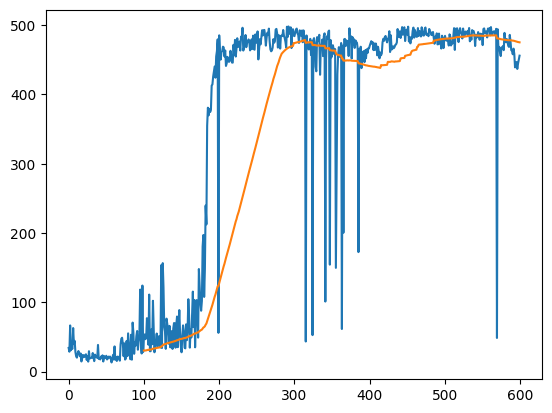

In [7]:
import matplotlib.pyplot as plt
plt.plot(scores)
smooth_size = 100
scores_smooth = []
scores_sum = sum(scores[:smooth_size])
for i in range(len(scores) - smooth_size):
    scores_sum += scores[i + smooth_size] - scores[i]
    scores_smooth.append(scores_sum / smooth_size)
plt.plot(range(smooth_size, len(scores)), scores_smooth)

In [8]:
env = gymnasium.make('CartPole-v2', render_mode='human')
valid_scores = []
for i in range(10):
    score = 0
    state, info = env.reset()
    while True:
        action = torch.argmax(target_q(torch.tensor(state))).cpu().detach().item()
        next_state, reward, terminated, truncated, info = env.step(action)
        score += reward
        state = next_state
        if terminated or truncated:
            break
    valid_scores.append(score)
env.close()
valid_scores

[474.9689630019676,
 452.1792129167165,
 459.49968579737543,
 454.46255444280405,
 479.6479765555749,
 475.3689622438227,
 463.36053840292294,
 441.93276036303814,
 478.48634914302306,
 448.2635728925]

In [9]:
env.close()

In [10]:
env = gymnasium.make('CartPole-v2')